# PyTorch Google deep dream and neural style transfer

We can use PyTorch to implement a Google deep dream - like algorithm to create "art" (trippy images ;-))

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

import requests
from io import BytesIO

## Use VGG as pretrained model

In [2]:
vgg = models.vgg16(pretrained = True)

if torch.cuda.is_available():
    vgg = vgg.cuda()
vgg.eval()

/home/user/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define some helper functions

In [3]:
denormalize = transforms.Compose([ 
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),                        
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),                                                     
])

class Hook():
    """
    Register a hook on the target layer (used to get the output channels of the layer)
    """
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()
  
def get_gradients(net_in, net, layer):   
    """ 
    Calculate gradients from the output channels of the target layer  
    """
    net_in = net_in.unsqueeze(0)
    if torch.cuda.is_available():
        net_in = net_in.cuda()
    net_in.requires_grad = True
    net.zero_grad()
    hook = Hook(layer)
    net_out = net(net_in)
    loss = hook.output[0].norm()
    loss.backward()
    return net_in.grad.data.squeeze()

def dream(image, net, layer, iterations, lr):
    """ 
    Runs google deep dream - like algorithm
    """
    image_tensor = transforms.ToTensor()(image)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
    for i in range(iterations):
        gradients = get_gradients(image_tensor, net, layer)
        image_tensor.data = image_tensor.data + lr * gradients.data

    img_out = image_tensor.detach().cpu()
    img_out = denormalize(img_out)
    img_out_np = img_out.numpy().transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
    return img_out_pil

## Input image

In [4]:
#!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz -P ./tmp/
#!tar -xf ./tmp/wiki.tar.gz -C ./tmp/

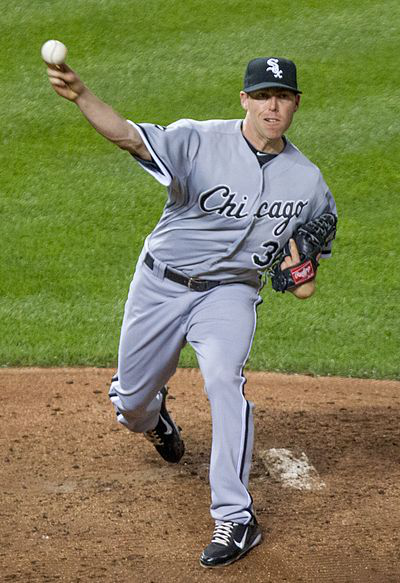

In [5]:
img = Image.open('./tmp/wiki/15/32993515_1985-07-30_2012.jpg')

from IPython.display import Image as Img

display(img)

## Run first deep dream

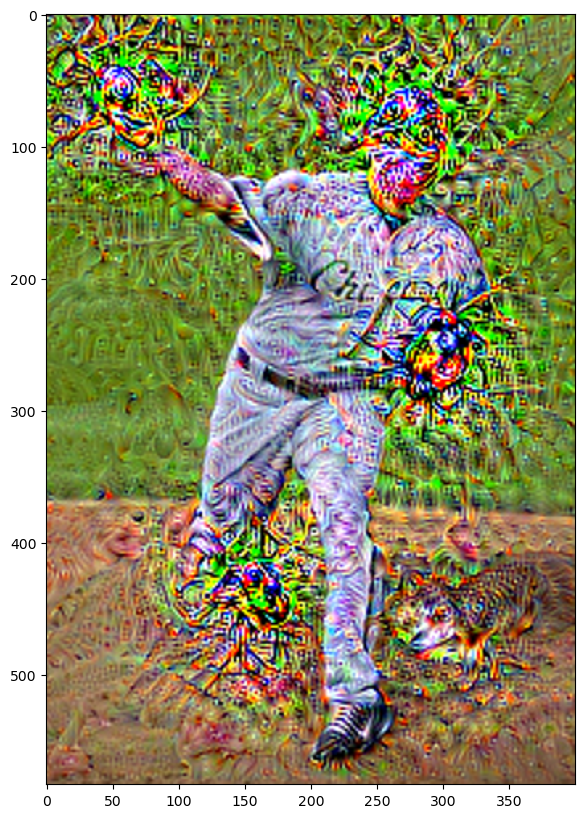

In [6]:
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))

# select a feature layer
layer = list( vgg.features.modules() )[27]

img = dream(img, vgg, layer, 20, 1)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

## Improving Deep Dream
It is easy to see that all the generated patterns have the same scale and are only resized to fit.  
We can improve this by resizing and rotating the images in the previously defined function and running the image through multiple iterations.

In [7]:
def dream(image, net, layer, iterations, lr):
    """ 
    Runs google deep dream - like algorithm
    """
    image_numpy = np.array(image)
    
    image_tensor = transforms.ToTensor()(image_numpy)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
        
    for i in range(iterations):
        roll_x = np.random.randint(image_numpy.shape[0])
        roll_y = np.random.randint(image_numpy.shape[1])
        img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
        img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
        gradients_np = get_gradients(img_roll_tensor, net, layer).detach().cpu().numpy()
        gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
        gradients_tensor = torch.tensor(gradients_np)
        if torch.cuda.is_available():
            gradients_tensor = gradients_tensor.cuda()
        image_tensor.data = image_tensor.data + lr * gradients_tensor.data

    img_out = image_tensor.detach().cpu()
    img_out = denormalize(img_out)
    img_out_np = img_out.numpy().transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
    return img_out_pil

In [8]:
def run_dream_scaled(image, model, layer, resizing_steps = 2, octave_scale = 1.5, iterations=30):
    for n in range(-(resizing_steps),1):
        new_size = orig_size * (octave_scale**n)
        image = image.resize(new_size.astype(int), Image.LANCZOS)
        image = dream(image, model, layer, iterations, 0.1)
    return image

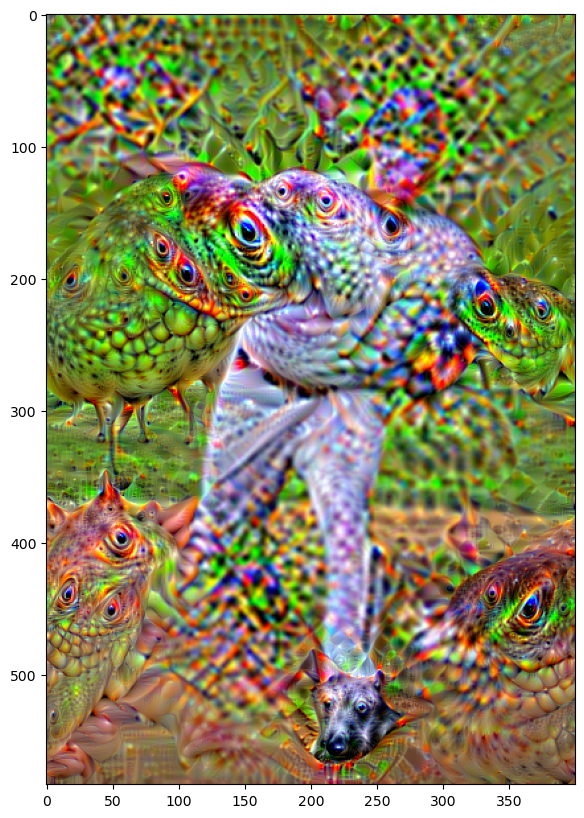

In [9]:
img = run_dream_scaled(img, vgg, layer, resizing_steps=3)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

Use another image and a different layer

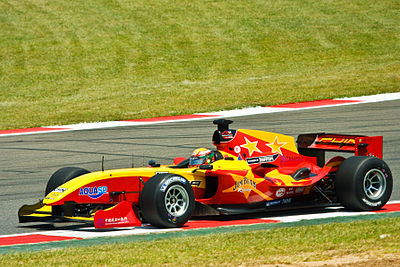

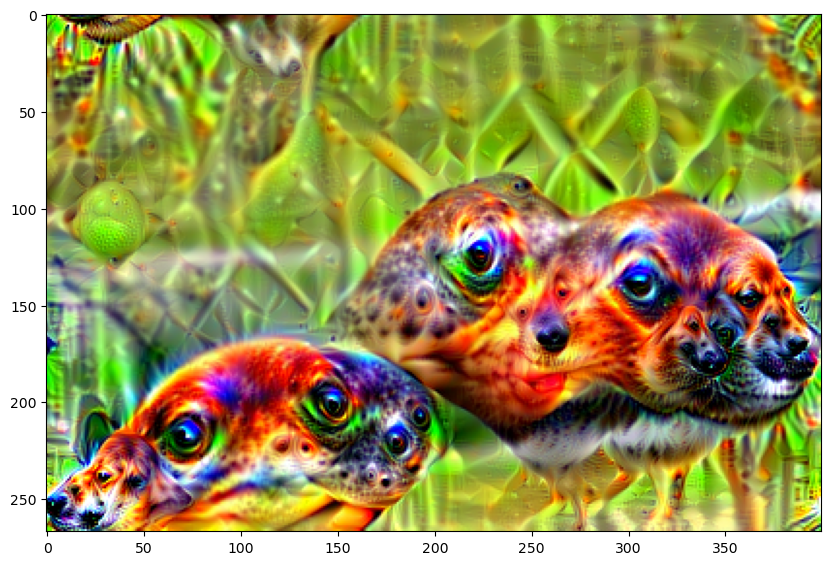

In [10]:
img = Image.open('./tmp/wiki/18/1156518_1982-12-04_2008.jpg')
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
display(img)

layer = list( vgg.features.modules() )[25]
img = run_dream_scaled(img, vgg, layer, resizing_steps=5)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

## Neural style transfer